##### load images

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = 'horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = 'horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

IMAGE_VECTOR_SIZE = 10000

train_data = np.empty((IMAGE_VECTOR_SIZE,0))
train_label = np.empty((0,1))
validation_data = np.empty((IMAGE_VECTOR_SIZE,0))
validation_label = np.empty((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    train_label = np.append(train_label, 1 if sum(labels)>0 else 0)  

# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):
    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    validation_data = np.hstack((validation_data, np.reshape(inputs, (10000,1))))
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    # human: 1, horse: 0
    validation_label = np.append(validation_label, 1 if sum(labels)>0 else 0)

In [2]:
train_data_num = len(train_data[0])
validation_data_num = len(validation_data[0])
train_offset_ones = np.ones((1,train_data_num))
validation_offset_ones = np.ones((1,validation_data_num))

train_set = np.insert(train_data, IMAGE_VECTOR_SIZE, train_offset_ones, 0)
validation_set = np.insert(validation_data, IMAGE_VECTOR_SIZE, validation_offset_ones, 0)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [22]:
def get_acc(discri, label):
    prediction = np.round(discri)
    equality = np.equal(prediction, label)
    return sum(equality[0]) / len(equality[0])

In [38]:
def get_loss(discri, label):
    return np.average(-label*np.log(discri) - (1-label)*np.log(np.ones(discri.shape)-discri))

In [48]:
u_vector = np.zeros((IMAGE_VECTOR_SIZE+1,1))

MAX_ITER = 10000
LR = 0.002

train_acc = list()
validation_acc = list()
train_loss = list()
validation_loss = list()

prev_loss = 0

for iter_num in range(0, MAX_ITER):
    discri = sigmoid(np.dot(np.transpose(u_vector), train_set)) # 판별식
    validation_discri = sigmoid(np.dot(np.transpose(u_vector), validation_set))
    train_acc.append(get_acc(discri, train_label))
    loss = get_loss(discri, train_label)
    train_loss.append(loss)
    if abs(prev_loss - loss) < 0.00005:
        break
    prev_loss = loss
    validation_acc.append(get_acc(validation_discri, validation_label))
    validation_loss.append(get_loss(validation_discri, validation_label))
    
    h_vector = np.transpose(discri - np.transpose(train_label))
    descent = np.dot(train_set, h_vector) / train_data_num
    u_vector = u_vector - LR * descent

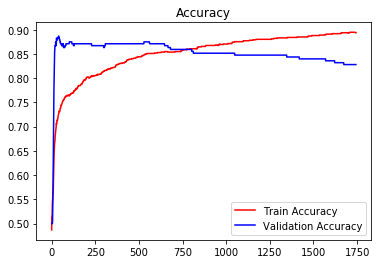

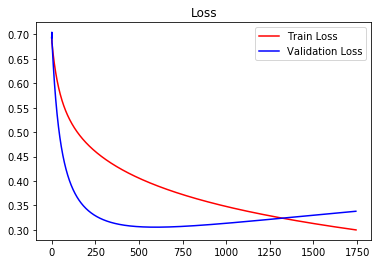

In [49]:
plt.plot(train_acc, color='#ff0000', label='Train Accuracy')
plt.plot(validation_acc, color='#0000ff', label='Validation Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.title('Accuracy')
plt.show()

plt.plot(train_loss, color='#ff0000', label='Train Accuracy')
plt.plot(validation_loss, color='#0000ff', label='Validation Accuracy')
plt.legend(['Train Loss','Validation Loss'])
plt.title('Loss')
plt.show()